In [1]:
import os
import sys

os.chdir("../..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Import custom FFNN implementation
import os
import sys
# Add the parent directory to path to import your modules
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from lib.neural import NeuralNetwork, NetworkLayer
from lib.ffnn import FFNN
from lib.activation import ReLU, Sigmoid, Tanh, Linear, Softmax
from lib.loss import MSE, BCE, CCE
from lib.weight_initializer import ZeroInitializer, UniformInitializer, NormalInitializer


INFO:root:Loading data


Sparsity with L1 penalty: 76.63%
Test score with L1 penalty: 0.8395
Example run in 9.434 s


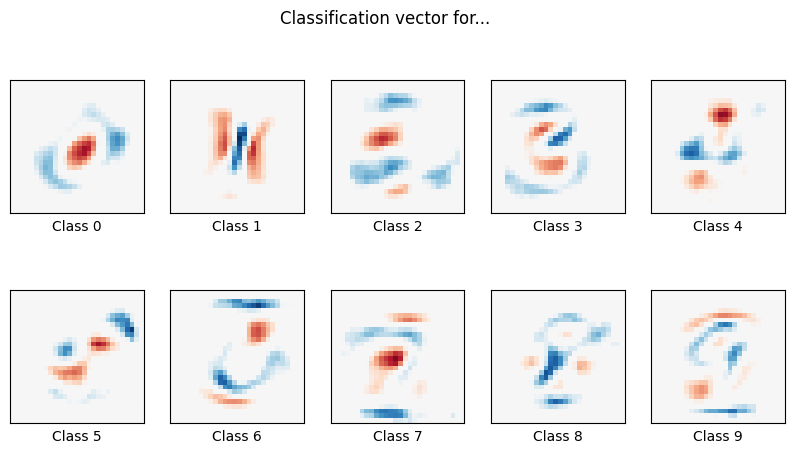

In [4]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import logging

logging.basicConfig(level=logging.INFO)

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
logging.info("Loading data")
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [5]:
# Preprocess data for FFNN
from sklearn.preprocessing import OneHotEncoder

# Load data (using your already loaded data)
# X_train and X_test are already loaded and scaled

# Convert labels to one-hot encoding for neural network
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Create validation set
X_train_ffnn, X_val, y_train_ffnn, y_val = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42
)



print(f"Training set: {X_train_ffnn.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Input features: {X_train.shape[1]}")
print(f"Output classes: {y_train_onehot.shape[1]}")


Training set: 4000 samples
Validation set: 1000 samples
Test set: 10000 samples
Input features: 784
Output classes: 10


In [ ]:
# Helper functions for evaluation and visualization
def evaluate_model(model, X, y_onehot):
    """Evaluate model accuracy on given data."""
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_onehot, axis=1)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy

def plot_train_history(history, title="Training History"):
    """Plot training and validation loss history."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [7]:
base_config = {
    'learning_rate': 0.32,
    'batch_size': 32,
    'epochs': 5,  
    'loss_function': CCE(),
    'activation': ReLU(),
    'initializer': NormalInitializer(seed=42)
}

Testing width variations...

Width Variation 1: [784, 32, 10]


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s, loss=0.8865]

Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 288.55it/s, loss=4.1196]


Epoch 1/5 - 0.47s - loss: 4.1196 - val_loss: 3.5540


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 502.90it/s, loss=2.9913]


Epoch 2/5 - 0.29s - loss: 2.9913 - val_loss: 3.2081


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 665.74it/s, loss=2.2574]


Epoch 3/5 - 0.22s - loss: 2.2574 - val_loss: 3.1859


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 718.75it/s, loss=2.2970]


Epoch 4/5 - 0.21s - loss: 2.2970 - val_loss: 4.0065


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 751.92it/s, loss=2.4470]


Epoch 5/5 - 0.22s - loss: 2.4470 - val_loss: 3.7072
Test accuracy: 0.8493

Width Variation 2: [784, 128, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:06<00:00, 19.99it/s, loss=7.6364]


Epoch 1/5 - 6.31s - loss: 7.6364 - val_loss: 5.1817


Epoch 2/5: 100%|██████████| 125/125 [00:06<00:00, 20.13it/s, loss=5.1939]


Epoch 2/5 - 6.28s - loss: 5.1939 - val_loss: 5.0625


Epoch 3/5: 100%|██████████| 125/125 [00:04<00:00, 26.08it/s, loss=4.1282]


Epoch 3/5 - 4.84s - loss: 4.1282 - val_loss: 3.5567


Epoch 4/5: 100%|██████████| 125/125 [00:05<00:00, 22.49it/s, loss=3.4651]


Epoch 4/5 - 5.62s - loss: 3.4651 - val_loss: 4.9352


Epoch 5/5: 100%|██████████| 125/125 [00:05<00:00, 21.13it/s, loss=3.7121]


Epoch 5/5 - 5.98s - loss: 3.7121 - val_loss: 4.5609
Test accuracy: 0.8663

Width Variation 3: [784, 512, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:05<00:00, 23.94it/s, loss=15.3635]


Epoch 1/5 - 5.30s - loss: 15.3635 - val_loss: 13.1007


Epoch 2/5: 100%|██████████| 125/125 [00:04<00:00, 26.04it/s, loss=12.7532]


Epoch 2/5 - 4.86s - loss: 12.7532 - val_loss: 12.9802


Epoch 3/5: 100%|██████████| 125/125 [00:04<00:00, 25.11it/s, loss=12.0289]


Epoch 3/5 - 5.07s - loss: 12.0289 - val_loss: 12.9774


Epoch 4/5: 100%|██████████| 125/125 [00:04<00:00, 26.90it/s, loss=11.9808]


Epoch 4/5 - 4.72s - loss: 11.9808 - val_loss: 12.5778


Epoch 5/5: 100%|██████████| 125/125 [00:03<00:00, 35.70it/s, loss=11.9053]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Epoch 5/5 - 3.55s - loss: 11.9053 - val_loss: 12.4892
Test accuracy: 0.6546


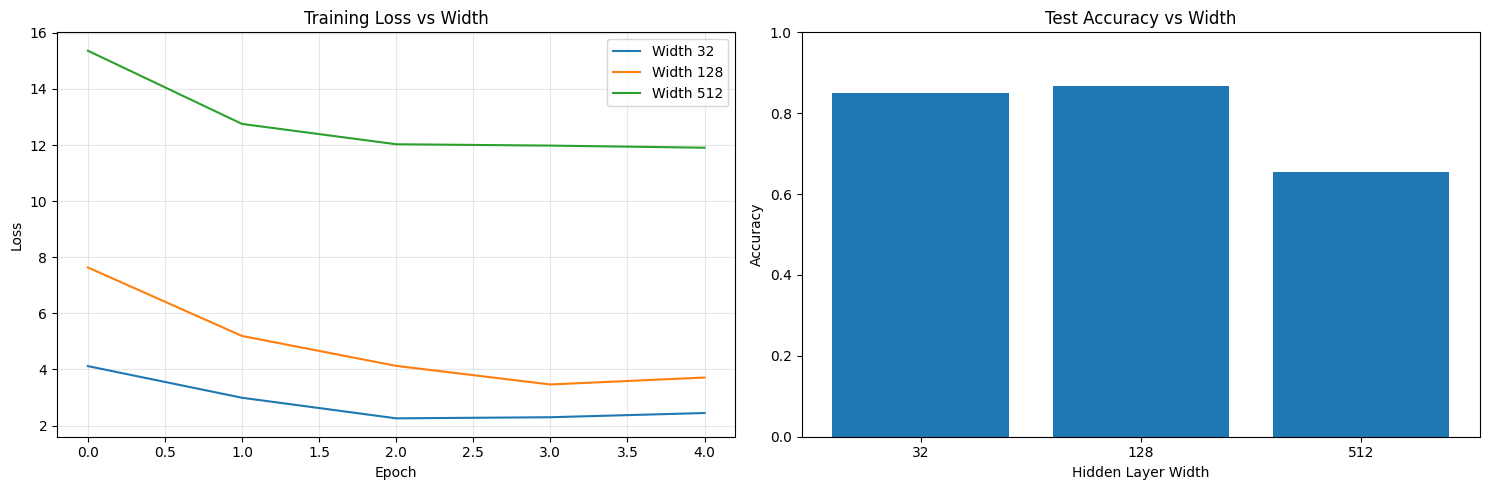


Testing depth variations...

Depth Variation 1: [784, 64, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:02<00:00, 60.71it/s, loss=5.2199]


Epoch 1/5 - 2.10s - loss: 5.2199 - val_loss: 4.4680


Epoch 2/5: 100%|██████████| 125/125 [00:02<00:00, 57.18it/s, loss=3.7062]


Epoch 2/5 - 2.22s - loss: 3.7062 - val_loss: 3.9893


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 72.88it/s, loss=3.3335]


Epoch 3/5 - 1.76s - loss: 3.3335 - val_loss: 4.3420


Epoch 4/5: 100%|██████████| 125/125 [00:02<00:00, 56.80it/s, loss=3.4087]


Epoch 4/5 - 2.24s - loss: 3.4087 - val_loss: 4.7675


Epoch 5/5: 100%|██████████| 125/125 [00:02<00:00, 49.46it/s, loss=3.4365]


Epoch 5/5 - 2.56s - loss: 3.4365 - val_loss: 4.8613
Test accuracy: 0.8389

Depth Variation 2: [784, 64, 64, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:02<00:00, 60.12it/s, loss=27.8532]


Epoch 1/5 - 2.13s - loss: 27.8532 - val_loss: 27.7346


Epoch 2/5: 100%|██████████| 125/125 [00:02<00:00, 61.08it/s, loss=27.6051]


Epoch 2/5 - 2.11s - loss: 27.6051 - val_loss: 26.8525


Epoch 3/5: 100%|██████████| 125/125 [00:02<00:00, 50.26it/s, loss=26.7182]


Epoch 3/5 - 2.55s - loss: 26.7182 - val_loss: 28.4600


Epoch 4/5: 100%|██████████| 125/125 [00:02<00:00, 53.41it/s, loss=27.8210]


Epoch 4/5 - 2.41s - loss: 27.8210 - val_loss: 28.4600


Epoch 5/5: 100%|██████████| 125/125 [00:03<00:00, 41.45it/s, loss=27.8210]


Epoch 5/5 - 3.11s - loss: 27.8210 - val_loss: 28.4600
Test accuracy: 0.1795

Depth Variation 3: [784, 64, 64, 64, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:02<00:00, 43.37it/s, loss=30.8686]


Epoch 1/5 - 3.00s - loss: 30.8686 - val_loss: 31.5339


Epoch 2/5: 100%|██████████| 125/125 [00:03<00:00, 35.92it/s, loss=30.8604]


Epoch 2/5 - 3.56s - loss: 30.8604 - val_loss: 31.5339


Epoch 3/5: 100%|██████████| 125/125 [00:03<00:00, 40.17it/s, loss=30.8604]


Epoch 3/5 - 3.20s - loss: 30.8604 - val_loss: 31.5339


Epoch 4/5: 100%|██████████| 125/125 [00:03<00:00, 40.98it/s, loss=30.8604]


Epoch 4/5 - 3.14s - loss: 30.8604 - val_loss: 31.5339


Epoch 5/5: 100%|██████████| 125/125 [00:02<00:00, 42.48it/s, loss=30.8604]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Epoch 5/5 - 3.03s - loss: 30.8604 - val_loss: 31.5339
Test accuracy: 0.0973


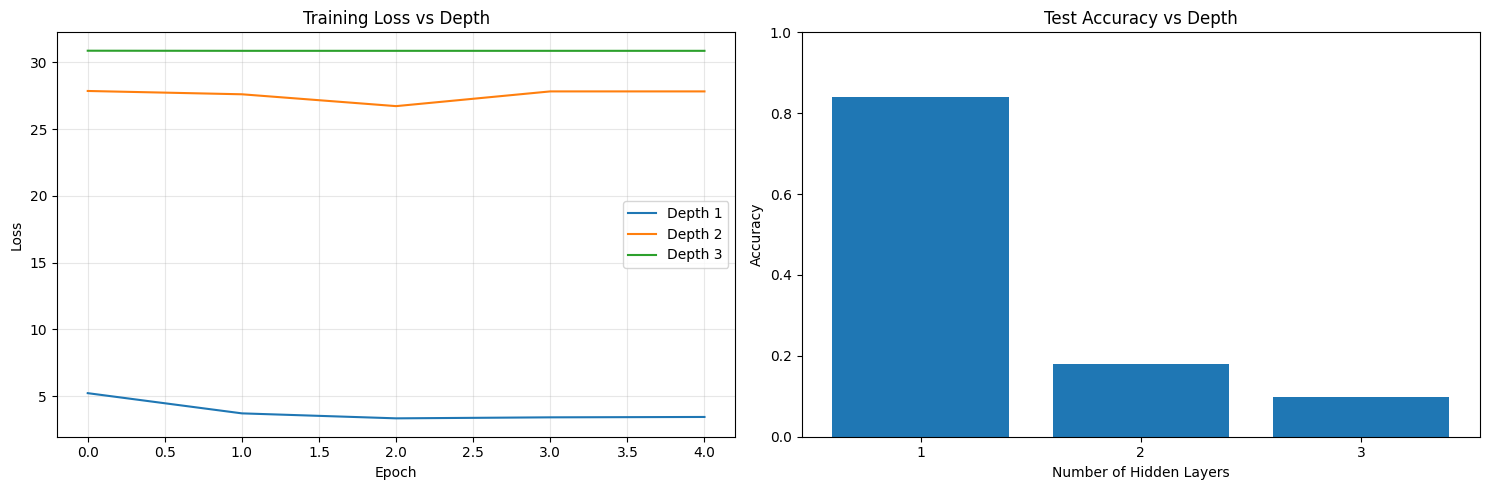

In [8]:


# Define different architectures for width variation (fixed depth)
width_variations = [
    [784, 32, 10],         # Narrow
    [784, 128, 10],        # Medium
    [784, 512, 10]         # Wide
]

# Define different architectures for depth variation (fixed width)
depth_variations = [
    [784, 64, 10],               # Shallow (1 hidden layer)
    [784, 64, 64, 10],           # Medium (2 hidden layers)
    [784, 64, 64, 64, 10]        # Deep (3 hidden layers)
]

# Test width variations
width_histories = []
width_accuracies = []

print("Testing width variations...")
for i, architecture in enumerate(width_variations):
    print(f"\nWidth Variation {i+1}: {architecture}")
    
    # Create activations list (output layer uses Softmax)
    activations = [base_config['activation']] * (len(architecture) - 2) + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=base_config['learning_rate'],
        verbose=1
    )
    
    # Store results
    width_histories.append(history)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    width_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot results for width variations
plt.figure(figsize=(15, 5))

# Plot width variation loss
plt.subplot(1, 2, 1)
for i, history in enumerate(width_histories):
    plt.plot(history['train_loss'], label=f"Width {width_variations[i][1]}")
plt.title('Training Loss vs Width')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare test accuracies for width
plt.subplot(1, 2, 2)
plt.bar([str(arch[1]) for arch in width_variations], width_accuracies)
plt.title('Test Accuracy vs Width')
plt.xlabel('Hidden Layer Width')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Test depth variations
depth_histories = []
depth_accuracies = []

print("\nTesting depth variations...")
for i, architecture in enumerate(depth_variations):
    print(f"\nDepth Variation {i+1}: {architecture}")
    
    # Create activations list (output layer uses Softmax)
    activations = [base_config['activation']] * (len(architecture) - 2) + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=base_config['learning_rate'],
        verbose=1
    )
    
    # Store results
    depth_histories.append(history)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    depth_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot results for depth variations
plt.figure(figsize=(15, 5))

# Plot depth variation loss
plt.subplot(1, 2, 1)
for i, history in enumerate(depth_histories):
    plt.plot(history['train_loss'], label=f"Depth {len(depth_variations[i]) - 2}")
plt.title('Training Loss vs Depth')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare test accuracies for depth
plt.subplot(1, 2, 2)
plt.bar([str(len(arch) - 2) for arch in depth_variations], depth_accuracies)
plt.title('Test Accuracy vs Depth')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Testing activation functions...


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 125/125 [00:07<00:00, 17.74it/s, loss=9.9833]


Epoch 1/5 - 7.10s - loss: 9.9833 - val_loss: 9.9365


Epoch 2/5: 100%|██████████| 125/125 [00:06<00:00, 19.45it/s, loss=8.5043]


Epoch 2/5 - 6.50s - loss: 8.5043 - val_loss: 9.3431


Epoch 3/5: 100%|██████████| 125/125 [00:06<00:00, 18.79it/s, loss=8.2002]


Epoch 3/5 - 6.73s - loss: 8.2002 - val_loss: 8.2012


Epoch 4/5: 100%|██████████| 125/125 [00:06<00:00, 19.92it/s, loss=7.7185]


Epoch 4/5 - 6.34s - loss: 7.7185 - val_loss: 8.2467


Epoch 5/5: 100%|██████████| 125/125 [00:05<00:00, 22.66it/s, loss=7.6798]


Epoch 5/5 - 5.60s - loss: 7.6798 - val_loss: 8.4983
Test accuracy: 0.7557


Epoch 1/5: 100%|██████████| 125/125 [00:04<00:00, 29.56it/s, loss=7.2606]


Epoch 1/5 - 4.29s - loss: 7.2606 - val_loss: 5.5167


Epoch 2/5: 100%|██████████| 125/125 [00:04<00:00, 30.55it/s, loss=4.8671]


Epoch 2/5 - 4.13s - loss: 4.8671 - val_loss: 4.6218


Epoch 3/5: 100%|██████████| 125/125 [00:05<00:00, 21.56it/s, loss=4.3956]


Epoch 3/5 - 5.87s - loss: 4.3956 - val_loss: 4.7157


Epoch 4/5: 100%|██████████| 125/125 [00:05<00:00, 21.52it/s, loss=3.9367]


Epoch 4/5 - 5.88s - loss: 3.9367 - val_loss: 4.8981


Epoch 5/5: 100%|██████████| 125/125 [00:06<00:00, 20.53it/s, loss=4.0892]


Epoch 5/5 - 6.16s - loss: 4.0892 - val_loss: 4.5860
Test accuracy: 0.8554


Epoch 1/5: 100%|██████████| 125/125 [00:05<00:00, 22.97it/s, loss=0.9988]


Epoch 1/5 - 5.52s - loss: 0.9988 - val_loss: 0.5762


Epoch 2/5: 100%|██████████| 125/125 [00:06<00:00, 18.10it/s, loss=0.3751]


Epoch 2/5 - 6.99s - loss: 0.3751 - val_loss: 0.4666


Epoch 3/5: 100%|██████████| 125/125 [00:06<00:00, 20.50it/s, loss=0.2575]


Epoch 3/5 - 6.18s - loss: 0.2575 - val_loss: 0.4399


Epoch 4/5: 100%|██████████| 125/125 [00:05<00:00, 22.15it/s, loss=0.1951]


Epoch 4/5 - 5.70s - loss: 0.1951 - val_loss: 0.4180


Epoch 5/5: 100%|██████████| 125/125 [00:05<00:00, 22.96it/s, loss=0.1518]


Epoch 5/5 - 5.51s - loss: 0.1518 - val_loss: 0.4130
Test accuracy: 0.8776


Epoch 1/5: 100%|██████████| 125/125 [00:06<00:00, 18.99it/s, loss=1.0142]


Epoch 1/5 - 6.64s - loss: 1.0142 - val_loss: 0.6050


Epoch 2/5: 100%|██████████| 125/125 [00:05<00:00, 23.24it/s, loss=0.2501]


Epoch 2/5 - 5.43s - loss: 0.2501 - val_loss: 0.5355


Epoch 3/5: 100%|██████████| 125/125 [00:06<00:00, 18.74it/s, loss=0.1167]


Epoch 3/5 - 6.68s - loss: 0.1167 - val_loss: 0.5436


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 364.48it/s, loss=0.0653]


Epoch 4/5 - 0.36s - loss: 0.0653 - val_loss: 0.5428


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 316.41it/s, loss=0.0431]


Epoch 5/5 - 0.40s - loss: 0.0431 - val_loss: 0.5370
Test accuracy: 0.8573


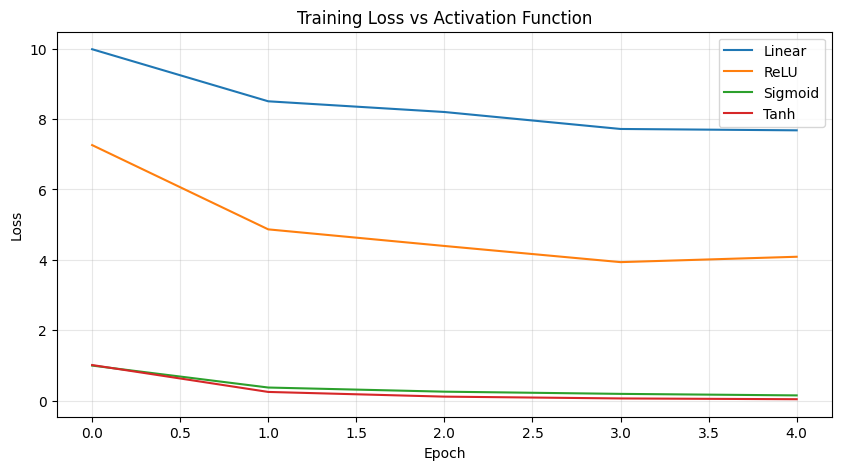

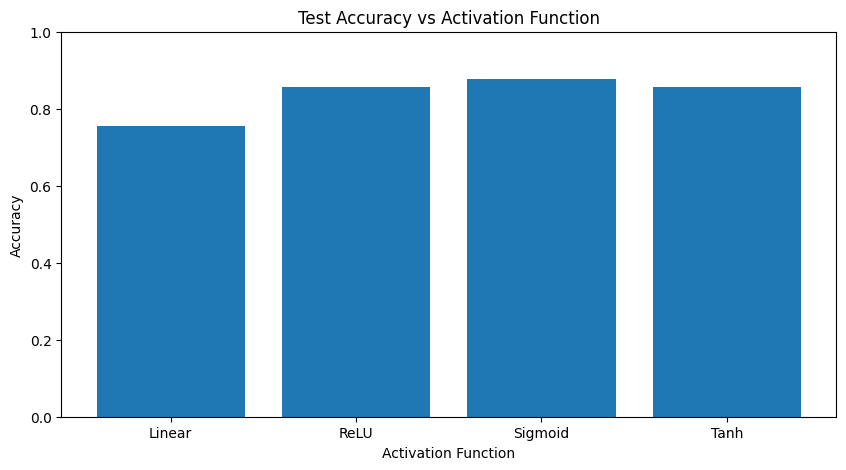

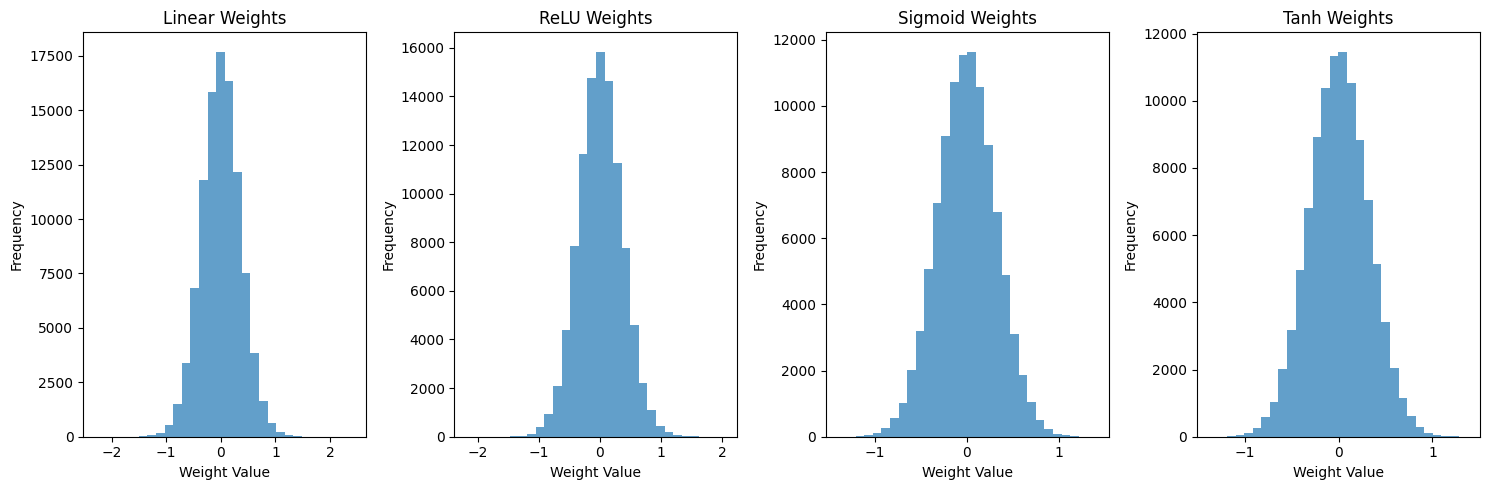

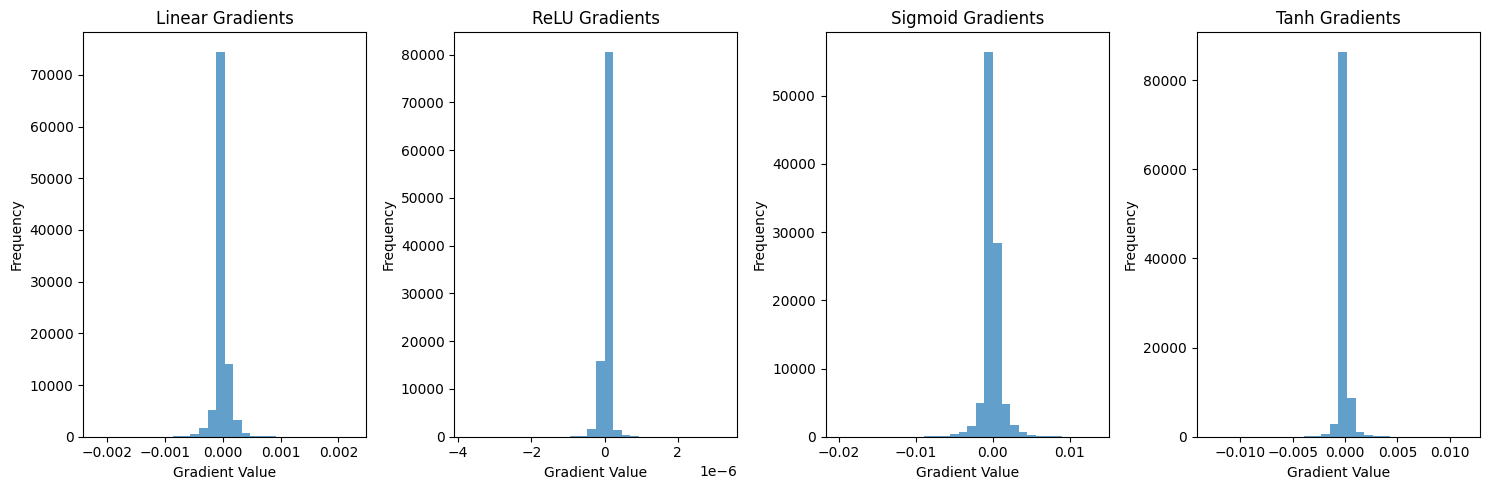

In [9]:
# Define base architecture
architecture = [784, 128, 10]

# Define activation functions to test (for hidden layers)
activation_functions = [Linear(), ReLU(), Sigmoid(), Tanh()]

# Test different activation functions
activation_histories = []
activation_accuracies = []
activation_models = []

print("Testing activation functions...")
for activation in activation_functions:
    # print(f"\nActivation: {activation.__class__.__name__}")
    
    # Create activations list (output layer uses Softmax)
    activations = [activation] + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=base_config['learning_rate'],
        verbose=1
    )
    
    # Store results
    activation_histories.append(history)
    activation_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    activation_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(activation_histories):
    plt.plot(history['train_loss'], label=f"{activation_functions[i].__class__.__name__}")
plt.title('Training Loss vs Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar([act.__class__.__name__ for act in activation_functions], activation_accuracies)
plt.title('Test Accuracy vs Activation Function')
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(activation_models):
    plt.subplot(1, len(activation_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"{activation_functions[i].__class__.__name__} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot gradient distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(activation_models):
    plt.subplot(1, len(activation_models), i+1)
    gradients = model.network.gradients[0].flatten()
    plt.hist(gradients, bins=30, alpha=0.7)
    plt.title(f"{activation_functions[i].__class__.__name__} Gradients")
    plt.xlabel("Gradient Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Testing learning rates...

Learning Rate: 0.001


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 303.28it/s, loss=19.4810]


Epoch 1/5 - 0.42s - loss: 19.4810 - val_loss: 16.4864


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 353.64it/s, loss=14.3744]


Epoch 2/5 - 0.36s - loss: 14.3744 - val_loss: 12.7930


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 347.59it/s, loss=10.9310]


Epoch 3/5 - 0.37s - loss: 10.9310 - val_loss: 10.0564


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 267.20it/s, loss=8.6275]


Epoch 4/5 - 0.48s - loss: 8.6275 - val_loss: 8.1952


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 355.28it/s, loss=7.1476]


Epoch 5/5 - 0.36s - loss: 7.1476 - val_loss: 6.9681
Test accuracy: 0.4799

Learning Rate: 0.01


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 307.94it/s, loss=9.0169]


Epoch 1/5 - 0.41s - loss: 9.0169 - val_loss: 4.2068


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 363.94it/s, loss=2.9953]


Epoch 2/5 - 0.35s - loss: 2.9953 - val_loss: 2.9517


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 340.05it/s, loss=1.9654]


Epoch 3/5 - 0.38s - loss: 1.9654 - val_loss: 2.5357


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 378.44it/s, loss=1.4409]


Epoch 4/5 - 0.34s - loss: 1.4409 - val_loss: 2.3201


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 268.90it/s, loss=1.0899]


Epoch 5/5 - 0.47s - loss: 1.0899 - val_loss: 2.1728
Test accuracy: 0.8086

Learning Rate: 0.1


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 345.72it/s, loss=4.1501]


Epoch 1/5 - 0.38s - loss: 4.1501 - val_loss: 2.5273


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 330.69it/s, loss=1.5654]


Epoch 2/5 - 0.39s - loss: 1.5654 - val_loss: 2.1541


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 390.16it/s, loss=1.1010]


Epoch 3/5 - 0.33s - loss: 1.1010 - val_loss: 2.1520


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 384.71it/s, loss=0.7927]


Epoch 4/5 - 0.33s - loss: 0.7927 - val_loss: 1.9948


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 274.86it/s, loss=0.4823]


Epoch 5/5 - 0.46s - loss: 0.4823 - val_loss: 2.0965
Test accuracy: 0.8853

Learning Rate: 0.32


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 358.28it/s, loss=9.4337]


Epoch 1/5 - 0.36s - loss: 9.4337 - val_loss: 8.4264


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 185.73it/s, loss=7.0418]


Epoch 2/5 - 0.68s - loss: 7.0418 - val_loss: 8.2077


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 270.04it/s, loss=6.4614]


Epoch 3/5 - 0.47s - loss: 6.4614 - val_loss: 7.6746


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 231.56it/s, loss=6.1667]


Epoch 4/5 - 0.55s - loss: 6.1667 - val_loss: 6.6158


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 290.19it/s, loss=6.0400]


Epoch 5/5 - 0.44s - loss: 6.0400 - val_loss: 6.7217
Test accuracy: 0.7811

Learning Rate: 0.5


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 106.44it/s, loss=11.3983]


Epoch 1/5 - 1.19s - loss: 11.3983 - val_loss: 9.4448


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 228.97it/s, loss=8.9325]


Epoch 2/5 - 0.56s - loss: 8.9325 - val_loss: 11.4270


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 295.95it/s, loss=9.5512]


Epoch 3/5 - 0.43s - loss: 9.5512 - val_loss: 9.2888


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 165.26it/s, loss=8.5588]


Epoch 4/5 - 0.77s - loss: 8.5588 - val_loss: 8.9354


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 250.23it/s, loss=7.8895]


Epoch 5/5 - 0.51s - loss: 7.8895 - val_loss: 9.3513
Test accuracy: 0.7307

Learning Rate: 1


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 291.90it/s, loss=18.7506]


Epoch 1/5 - 0.44s - loss: 18.7506 - val_loss: 22.2062


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 152.73it/s, loss=19.6788]


Epoch 2/5 - 0.83s - loss: 19.6788 - val_loss: 21.5371


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 230.96it/s, loss=19.9963]


Epoch 3/5 - 0.55s - loss: 19.9963 - val_loss: 18.4082


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 221.23it/s, loss=17.8615]


Epoch 4/5 - 0.57s - loss: 17.8615 - val_loss: 20.7083


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 326.85it/s, loss=17.3665]


Epoch 5/5 - 0.39s - loss: 17.3665 - val_loss: 19.1715
Test accuracy: 0.4464


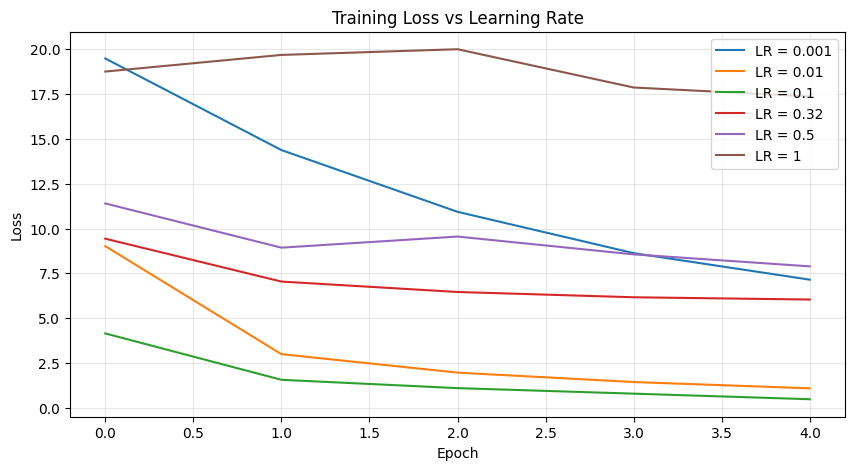

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


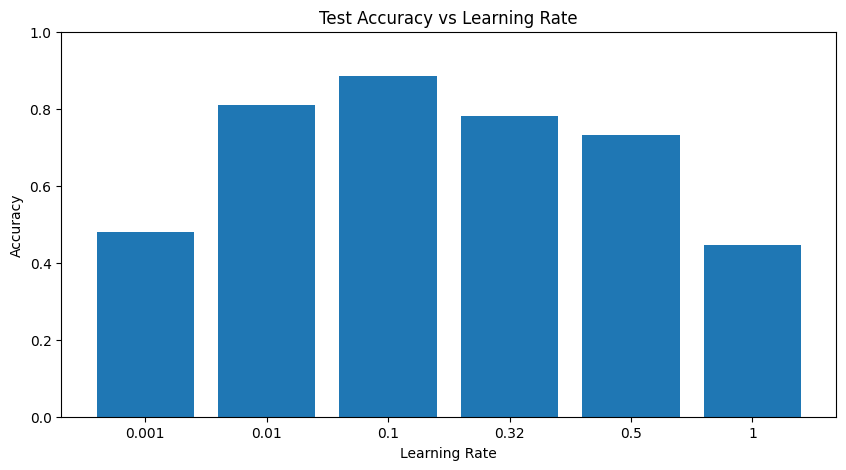

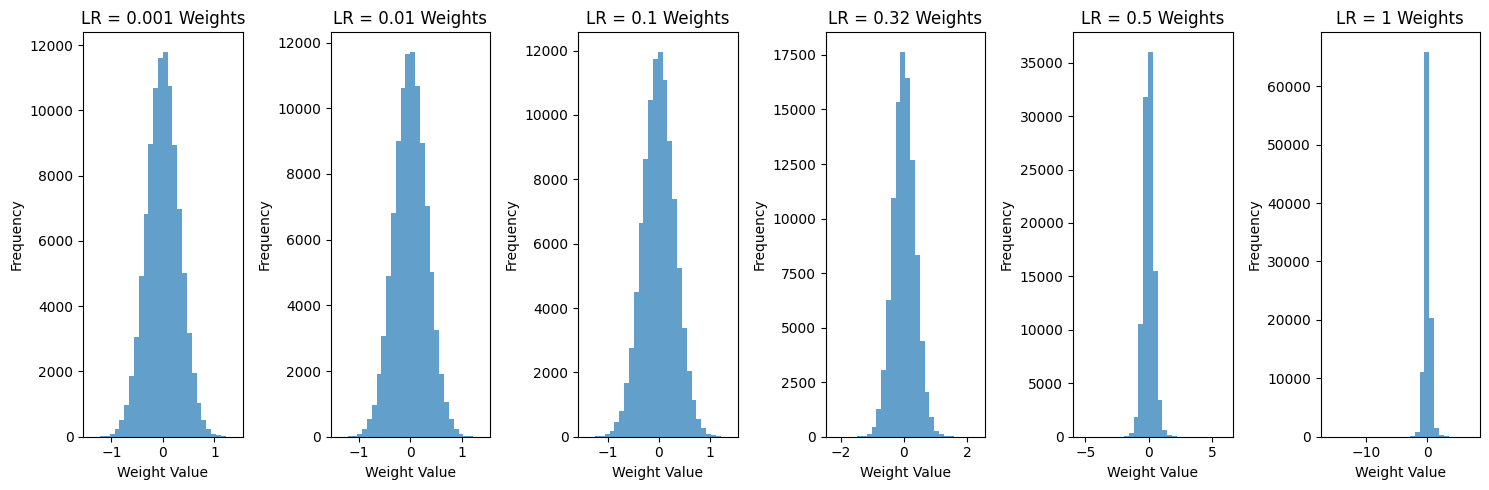

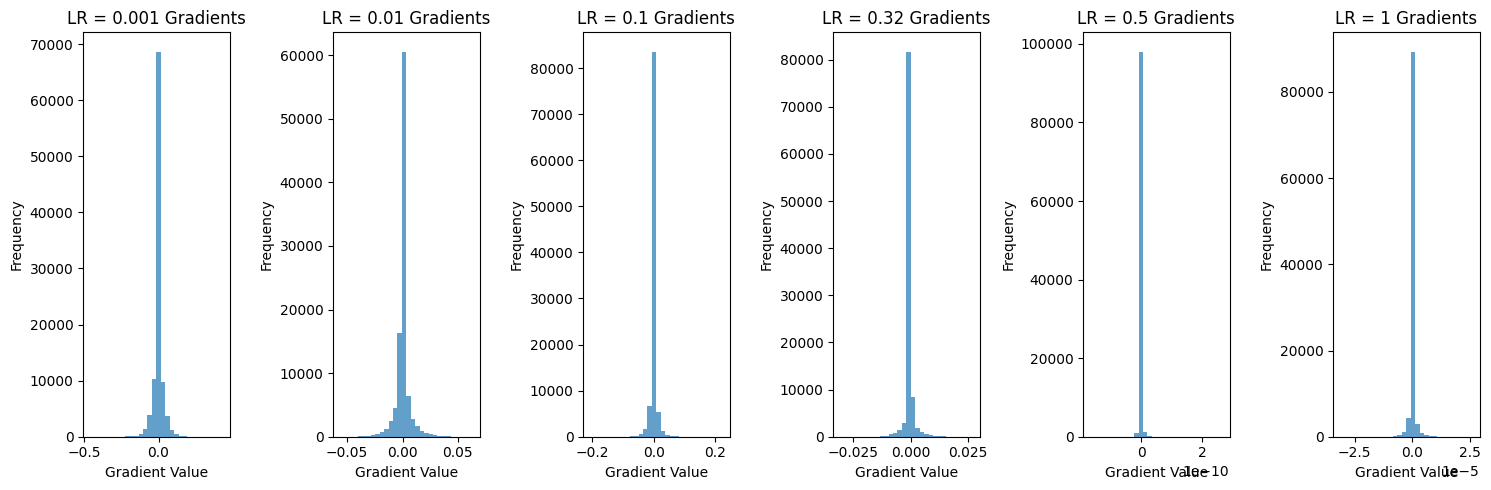

In [10]:
# Define base architecture
architecture = [784, 128, 10]

# Define learning rates to test
learning_rates = [0.001, 0.01, 0.1, 0.32, 0.5, 1]

# Test different learning rates
lr_histories = []
lr_accuracies = []
lr_models = []

print("Testing learning rates...")
for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    
    # Create activations list (output layer uses Softmax)
    activations = [ReLU()] + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=base_config['initializer']
    )
    
    # Create FFNN model
    # model = FFNN(network, learning_rate=lr)
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=lr,
        verbose=1
    )
    
    # Store results
    lr_histories.append(history)
    lr_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    lr_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(lr_histories):
    plt.plot(history['train_loss'], label=f"LR = {learning_rates[i]}")
plt.title('Training Loss vs Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar([str(lr) for lr in learning_rates], lr_accuracies)
plt.title('Test Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(lr_models):
    plt.subplot(1, len(lr_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"LR = {learning_rates[i]} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot gradient distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(lr_models):
    plt.subplot(1, len(lr_models), i+1)
    gradients = model.network.gradients[0].flatten()
    plt.hist(gradients, bins=30, alpha=0.7)
    plt.title(f"LR = {learning_rates[i]} Gradients")
    plt.xlabel("Gradient Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Testing weight initializers...

Initializer: Zero


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 310.64it/s, loss=2.3041]


Epoch 1/5 - 0.41s - loss: 2.3041 - val_loss: 2.3025


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 362.60it/s, loss=2.3035]


Epoch 2/5 - 0.35s - loss: 2.3035 - val_loss: 2.3038


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 290.26it/s, loss=2.3040]


Epoch 3/5 - 0.44s - loss: 2.3040 - val_loss: 2.3044


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 318.68it/s, loss=2.3035]


Epoch 4/5 - 0.40s - loss: 2.3035 - val_loss: 2.3050


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 196.45it/s, loss=2.3033]


Epoch 5/5 - 0.68s - loss: 2.3033 - val_loss: 2.3055
Test accuracy: 0.1060

Initializer: Uniform


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 336.92it/s, loss=0.7437]


Epoch 1/5 - 0.38s - loss: 0.7437 - val_loss: 0.5643


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 307.45it/s, loss=0.3659]


Epoch 2/5 - 0.42s - loss: 0.3659 - val_loss: 0.6155


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 211.45it/s, loss=0.2219]


Epoch 3/5 - 0.61s - loss: 0.2219 - val_loss: 0.6633


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 195.40it/s, loss=0.1230]


Epoch 4/5 - 0.65s - loss: 0.1230 - val_loss: 0.5050


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 193.96it/s, loss=0.0788]


Epoch 5/5 - 0.65s - loss: 0.0788 - val_loss: 0.5703
Test accuracy: 0.8969

Initializer: Normal


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 295.45it/s, loss=9.5295]


Epoch 1/5 - 0.44s - loss: 9.5295 - val_loss: 8.8204


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 319.51it/s, loss=7.3205]


Epoch 2/5 - 0.40s - loss: 7.3205 - val_loss: 8.0326


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 116.08it/s, loss=6.7986]


Epoch 3/5 - 1.09s - loss: 6.7986 - val_loss: 7.6292


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 361.11it/s, loss=5.8624]


Epoch 4/5 - 0.35s - loss: 5.8624 - val_loss: 8.3939


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 254.50it/s, loss=6.2923]


Epoch 5/5 - 0.50s - loss: 6.2923 - val_loss: 7.9786
Test accuracy: 0.7690


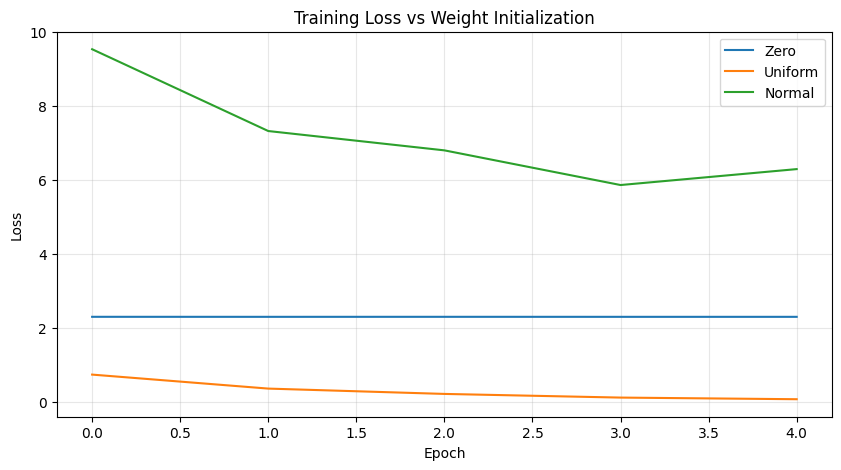

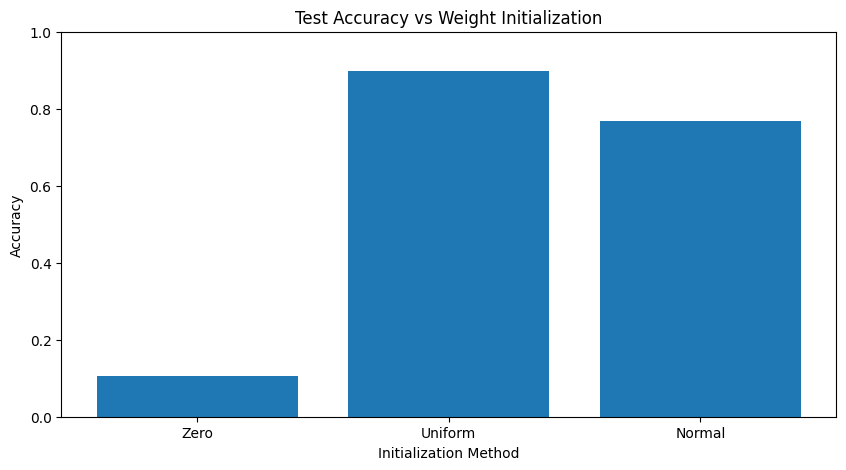

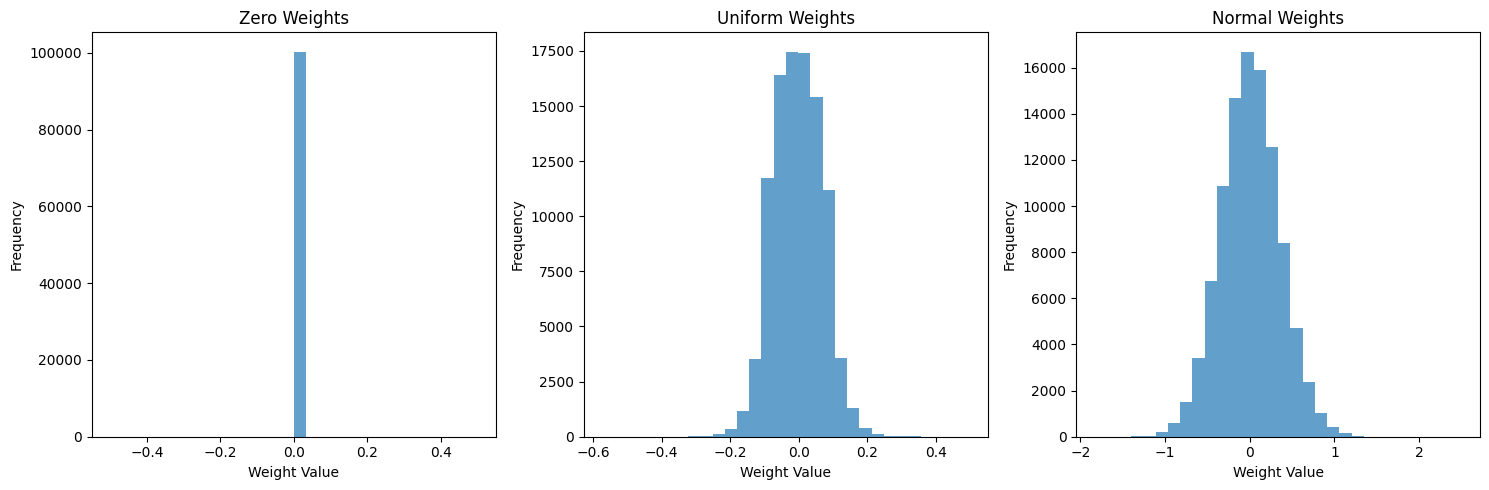

In [11]:
# Define base architecture
architecture = [784, 128, 10]

# Define initializers to test
initializers = [
    ZeroInitializer(),
    UniformInitializer(low=-0.1, high=0.1, seed=42),
    NormalInitializer(mean=0, var=0.1, seed=42)
]
initializer_names = ["Zero", "Uniform", "Normal"]

# Test different initializers
init_histories = []
init_accuracies = []
init_models = []

print("Testing weight initializers...")
for i, initializer in enumerate(initializers):
    print(f"\nInitializer: {initializer_names[i]}")
    
    # Create activations list (output layer uses Softmax)
    activations = [ReLU()] + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=initializer
    )
    
    # Create FFNN model
    # model = FFNN(network, learning_rate=base_config['learning_rate'])
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        verbose=1, learning_rate=base_config['learning_rate']
    )
    
    # Store results
    init_histories.append(history)
    init_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    init_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(init_histories):
    plt.plot(history['train_loss'], label=f"{initializer_names[i]}")
plt.title('Training Loss vs Weight Initialization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar(initializer_names, init_accuracies)
plt.title('Test Accuracy vs Weight Initialization')
plt.xlabel('Initialization Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot initial weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(init_models):
    plt.subplot(1, len(init_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"{initializer_names[i]} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Training custom FFNN model...


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 178.40it/s, loss=9.3601]


Epoch 1/5 - 0.71s - loss: 9.3601 - val_loss: 8.2976


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 124.44it/s, loss=7.2229]


Epoch 2/5 - 1.02s - loss: 7.2229 - val_loss: 7.9033


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 89.65it/s, loss=6.6424] 


Epoch 3/5 - 1.41s - loss: 6.6424 - val_loss: 7.8214


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 210.91it/s, loss=6.6685]


Epoch 4/5 - 0.60s - loss: 6.6685 - val_loss: 8.1478


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 255.94it/s, loss=6.4625]


Epoch 5/5 - 0.50s - loss: 6.4625 - val_loss: 7.6714

Training sklearn MLPClassifier...
First few training labels: [2 9 0 4 0]
Label type: <class 'numpy.ndarray'> int64
Iteration 1, loss = 12410280793331182.00000000
Iteration 2, loss = 497132877288924173032688208415165513728.00000000
Iteration 3, loss = 7201935559289790520065850888776002282775681296737794063859712.00000000
Iteration 4, loss = 540346410273574015797038134241453891107597090566059816593771032590388426796733300736.00000000
Iteration 5, loss = 8837955848106620000752134007503491472038304986202992006354116253243497196875628268687782095369610582818816.00000000

Model Comparison:
Custom FFNN accuracy: 0.7739
sklearn MLP accuracy: 0.2084


/home/ganadipa/code/kuliah/sem6/Machine-learning/tubes-1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


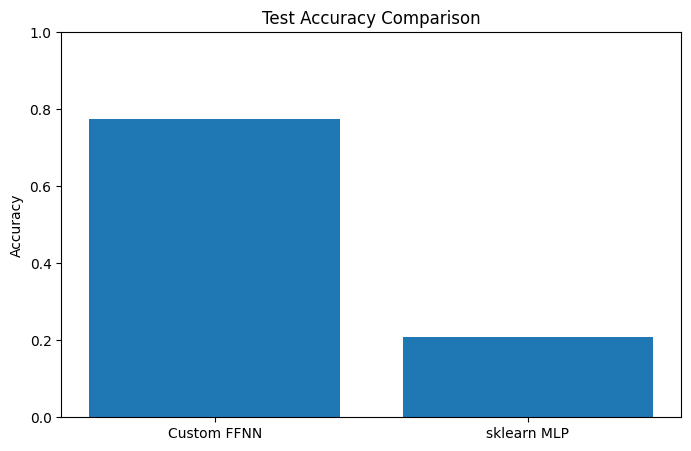

In [12]:
# Import sklearn's MLPClassifier
from sklearn.neural_network import MLPClassifier

# Define architecture and parameters
architecture = [784, 128, 10]
learning_rate = 0.32
batch_size = 32
epochs = 5

# Create our custom FFNN
activations = [ReLU()] + [Softmax()]
network = NeuralNetwork(
    node_counts=architecture,
    activations=activations,
    loss_function=CCE(),
    initialize_methods=NormalInitializer(seed=42)
)
custom_model = FFNN(network)

# Train our custom model
print("Training custom FFNN model...")
custom_history = custom_model.fit(
    X_train_ffnn, y_train_ffnn,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    learning_rate=learning_rate,
    verbose=1
)

# Create sklearn MLPClassifier
sklearn_model = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation='relu',
    solver='sgd',
    alpha=0.0001,
    batch_size=batch_size,
    learning_rate_init=learning_rate,
    max_iter=epochs,
    random_state=42,
    verbose=True
)

# Train sklearn model with correct target format
print("\nTraining sklearn MLPClassifier...")
# Convert string labels to integers if needed
y_train_int = np.array(y_train).astype(int) if isinstance(y_train[0], str) else np.array(y_train, dtype=int)
y_test_int = np.array(y_test).astype(int) if isinstance(y_test[0], str) else np.array(y_test, dtype=int)

# Check first few labels to debug
print(f"First few training labels: {y_train_int[:5]}")
print(f"Label type: {type(y_train_int)} {y_train_int.dtype}")

# Fit the model
sklearn_model.fit(X_train, y_train_int)

# Evaluate both models
custom_accuracy = evaluate_model(custom_model, X_test, y_test_onehot)
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_accuracy = np.mean(sklearn_predictions == y_test_int)

print("\nModel Comparison:")
print(f"Custom FFNN accuracy: {custom_accuracy:.4f}")
print(f"sklearn MLP accuracy: {sklearn_accuracy:.4f}")

# Compare accuracies
plt.figure(figsize=(8, 5))
plt.bar(['Custom FFNN', 'sklearn MLP'], [custom_accuracy, sklearn_accuracy])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()